In [1]:
from scipy.stats import mannwhitneyu, wilcoxon 
import pandas as pd
import itertools as it
import os
import seaborn as sns
sns.set(font_scale=1.5, style='white')

figdir = '../../paper/figs/'

print('figdir:',figdir)
def save(h=None,name='tmp'):
    name = name.strip().replace(' ','-').replace('%','pct')
    if h == None:
        h = plt.gcf()
    h.tight_layout()
    print('saving',figdir+'/'+name+'.pdf')
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    plt.savefig(figdir+'/'+name+'.pdf', bbox_inches='tight')

figdir: ../../paper/figs/


In [2]:
import pdb
import numpy as np

def pairwise_pval(df, metric, alg1, alg2):
    df = df.loc[df.algorithm.isin([alg1, alg2]),:].copy()
    x = df.loc[df.algorithm==alg1, metric].values 
    y = df.loc[df.algorithm==alg2, metric].values 
    eff_size = np.abs(np.nanmedian(x)/np.nanmedian(y))
    if metric.endswith('norm'):
        rmetric = metric.replace('norm','rank')
    else:
        rmetric = metric+'_rank'
    if rmetric not in df.columns:
        rmetric = metric
        
    x_rank = df.loc[df.algorithm==alg1, rmetric].values 
    y_rank = df.loc[df.algorithm==alg2, rmetric].values 
#     pdb.set_trace()
    if len(x) != len(y):
        print(alg1, len(x))
        print(alg2, len(y))
    assert len(x) == len(y)
#     w, p = mannwhitneyu(x, y)
    if all(y==0) and all(x==0):
        return 1, 1
    
    w, p = wilcoxon(x, y)
    return p, eff_size

#     return pstr, eff_size_str

def signif(pval, alpha, eff):
    pstr = '{:1.2g}'.format(pval)
    eff_size_str = '{:1.1f}X'.format(eff)
    if pval == '-': return pval
    if float(pval) < alpha:
        return 'textbf{'+pstr+'}', 'textbf{'+eff_size_str+'}'
#         return pval+'*'
    else:
        return pstr, eff_size_str
    
def get_pval_df(df, metric, all_algs):
    df = df.copy()
    n=0
    pvals = []
    for alg1, alg2 in it.combinations(all_algs, 2):
        pval, eff_size = pairwise_pval(df, metric, alg1, alg2)
        pvals.append(dict(
            alg1 = alg1,
            alg2 = alg2,
            eff_size = eff_size,
            pval = pval
        ))
        n += 1
    c_alpha = alpha/n


    print('n:',n,'c_alpha:',c_alpha) 
    df_pvals = pd.DataFrame.from_records(pvals)
    # df_pvals['pval_thresh'] = pd.cut(x=df_pvals['pval'], bins = [0, c_alpha, 1])
    df_pvals['pval_thresh'] = df_pvals['pval'].apply(lambda x: bin_pval(x, c_alpha))

    # significance
    df_pvals.loc[:,'pval_bold'] = df_pvals.apply(lambda x: signif(x['pval'], 
                                                                      c_alpha,
                                                                      x['eff_size'])[0],
                                                     axis=1
                                                    )
    df_pvals.loc[:,'eff_size_bold'] = df_pvals.apply(lambda x: signif(x['pval'], 
                                                                      c_alpha,
                                                                      x['eff_size'])[1],
                                                     axis=1
                                                    )
    return df_pvals, c_alpha

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

def bin_pval(x, c_alpha):

    for stars,level in zip([4,3,2,1],[1e-3, 1e-2, 1e-1, 1]):
        if x < level*c_alpha: 
            return stars #level #*c_alpha
    return 0

def pval_heatmap(df, metric, problem, algs):
    df = df.copy()
    n = 0 
    pvals = []

    df_pvals, c_alpha = get_pval_df(df, metric, algs)
    
    #                                                  pd.cut(x=df_pvals['pval'], bins = [0, c_alpha, 1])
    tbl = df_pvals.set_index(['alg1','alg2'])['pval_thresh'].unstack().transpose() #.fillna('-')
    # pval bins
    # df_cut = pd.cut(x=df_pvals['pval'], bins = [0, c_alpha, 1])
    # tbl = tbl.apply(lambda: )

    mask = np.zeros_like(tbl, dtype=np.bool)
    mask[np.triu_indices_from(mask,k=1)] = True

    h = plt.figure(figsize=(10,10))

    # cax = h.colorbar()
    cmap = sns.color_palette('flare',n_colors=5)
    cmap[0] = [.9, .9, .9]
    ax = sns.heatmap(tbl, 
#                 annot=True, 
    #             fmt='.1f', 
    #             fmt='.1g', 
                linewidth=0.25,
                mask=mask,
                square=True,
    #             norm = LogNorm(1e-3, 2),
                cbar_kws=dict(
                              ticks = [0.4, 1.2, 2.0, 2.8, 3.6],
#                               ticks=np.linspace(0,4,6),
                                
#                               ticks = []
                              shrink=0.6,
                ),
                cmap=cmap,

               )
    cax = h.axes[-1]
    # cax.set_yticks([0, 1, 2, 3, 4])
    cbar_labels = [
                   'no significance',
                   '$p<\\alpha$',
                   '$p<$1e-1$\cdot \\alpha$',
                   '$p<$1e-2$\cdot \\alpha$',
                   '$p<$1e-3$\cdot \\alpha$',
    #                '$p<\\alpha*$1e-3',
    #                '**',
    #                '***',
    #                '****'
                  ]
    cax.set_yticklabels(cbar_labels)
#     cax.
    nice_metric = metric.replace('%','pct').replace('_',' ').replace('R2','$$R^2$$').title()
    plt.title(('Wilcoxon signed-rank test, '
              +nice_metric
              +', $\\alpha =$ {:1.1e}').format(c_alpha)
             )
    plt.xlabel('')
    plt.ylabel('')
    savename = ('Pairwise comparison of '
              +nice_metric
              +' on '
              +problem).replace(' ','_')
    save(h, savename)

In [4]:
cmap = sns.color_palette('flare',n_colors=5)
cmap[0] = [1, 1, 1]
cmap

[[1, 1, 1],
 (0.87199254, 0.3633634, 0.35974223),
 (0.75861834, 0.25356035, 0.40663694),
 (0.60407977, 0.21017746, 0.43913439),
 (0.44584668, 0.17360625, 0.43114133)]

# symbolic datasets

## load data and fill nan results

In [5]:
df_sum = pd.read_csv('symbolic_dataset_results_sum.csv.gz')
algs = df_sum.algorithm.unique()
datasets = df_sum.dataset.unique()
noises = df_sum.target_noise.unique()

df_sum
cols = df_sum.columns
for col in [c for c in cols if 'rank' in c]:
    df_sum.loc[:,col] = df_sum[col].fillna(len(algs)+1)
for col in [c for c in cols if 'solution_rate' in c]:
    df_sum.loc[:,col] = df_sum[col].fillna(0.0)

In [6]:
cols = df_sum.columns
filler_frame = {
    'r2_test' : 0.0,
    'solution_rate_(%)' : 0.0,
}
fill_frames = []

for dataset in datasets:
    for noise in noises:
        for alg in algs:
            df = df_sum.loc[df_sum.dataset == dataset].loc[df_sum.target_noise==noise]
            if alg not in df.algorithm.unique():
                print(alg,'missing for',dataset, noise)
#                 for col in cols:
                new_fill = filler_frame.copy()
                new_fill.update({
                                 'algorithm':alg,
                                 'dataset':dataset,
                                 'target_noise':noise
                                })
                fill_frames.append(new_fill)
df_fill = pd.DataFrame.from_records(fill_frames, columns=fill_frames[0].keys()) 
df_sum_filled = df_sum.append(df_fill)


AIFeynman missing for feynman_III_15_14 0.001
AIFeynman missing for feynman_III_8_54 0.0
AIFeynman missing for feynman_II_21_32 0.001
AIFeynman missing for feynman_II_27_16 0.01
AIFeynman missing for feynman_II_34_11 0.01
AIFeynman missing for feynman_II_34_2 0.01
AIFeynman missing for feynman_I_12_4 0.001
AIFeynman missing for feynman_I_30_3 0.01
AIFeynman missing for feynman_I_44_4 0.01
AIFeynman missing for feynman_test_1 0.01
AIFeynman missing for feynman_test_13 0.0
AIFeynman missing for feynman_test_17 0.01
AIFeynman missing for feynman_test_20 0.01
AIFeynman missing for feynman_test_9 0.01


## generate tables

In [7]:
alpha = 0.05
SR_pvals = {}

for metric in ['r2_test','symbolic_solution_rate','simplified_complexity']:
    for target_noise, dfg in df_sum_filled.groupby('target_noise'):
        print(metric, 'noise=',target_noise)
        df_pvals, c_alpha = get_pval_df(df_sum_filled, metric, algs) 

        pval_tbl = df_pvals.set_index(['alg1','alg2'])['pval_bold'].unstack().fillna('-')
        disp_tbl = df_pvals.set_index(['alg1','alg2'])['pval'].unstack().fillna('-')
        SR_pvals[metric] = {target_noise:disp_tbl}
        display(disp_tbl)

        caption = ('Pairwise comparisons of {} across the symbolic datasets. '
                  'Bold indicates significant differences ($p<\\alpha$, $\\alpha=${:1.1g}).').format(
                        metric.replace('_',' ').replace('%','\%').title(), 
                        c_alpha
                        )
        tbl = pval_tbl.to_latex(
                          caption=caption,
    #                       formatters=[lambda x: signif(x, corrected_alpha) for c in pval_tbl.columns],
    #                       label='tbl:pval-sr-'+metric.replace('_','-')
                         )
        tbl = tbl.replace('\centering','\centering\n\\tiny')
        tbl = tbl.replace('textbf','\\textbf')
        tbl = tbl.replace('\\{','{').replace('\\}','}')
        print(tbl)
        with open('../../paper/tables/pvals_symbolic_'+metric.replace('%','pct')
                  +'_target-noise'+str(target_noise)+'.tex','w') as f:
            f.write(tbl)
        pval_tbl

r2_test noise= 0.0
n: 91 c_alpha: 0.0005494505494505495


alg2,AFP_FE,AIFeynman,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP,gplearn
alg1,,,,,,,,,,,,,
AFP,0.0,0.0,0.0,0.0,0.095025,0.0,0.0,0.0,0.0,0.0,0.0,0.000377,1.314635e-18
AFP_FE,-,0.0,0.0,0.0,0.000028,0.0,0.0,0.0,0.0,0.0,0.104294,0.03543,2.267152e-41
AIFeynman,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.580877e-36
BSR,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.000002,0.0,0.0,4.981820e-24
DSR,-,-,-,-,0.0,0.156487,0.000028,0.0,0.0,0.0,0.0,0.0,3.723889e-06
EPLEX,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.000087,5.050599e-17
FEAT,-,-,-,-,-,-,0.072373,0.0,0.036466,0.0,0.0,0.0,8.033778e-02
FFX,-,-,-,-,-,-,-,0.0,0.121067,0.0,0.0,0.0,4.028489e-01
GP-GOMEA,-,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,2.450720e-45


\begin{table}
\centering
\tiny
\caption{Pairwise comparisons of R2 Test across the symbolic datasets. Bold indicates significant differences ($p<\alpha$, $\alpha=$0.0005).}
\begin{tabular}{llllllllllllll}
\toprule
alg2 &           AFP\_FE &        AIFeynman &              BSR &              DSR &            EPLEX &             FEAT &              FFX &         GP-GOMEA &             ITEA &             MRGP &           Operon &              SBP &          gplearn \\
alg1      &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  \\
\midrule
AFP       &  \textbf{1.8e-31} &  \textbf{7.8e-38} &  \textbf{8.1e-57} &  \textbf{1.4e-46} &            0.095 &  \textbf{7.4e-22} &  \textbf{1.9e-27} &  \textbf{2.2e-25} &  \textbf{2.8e-28} &  \textbf{7.6e-33} &  \textbf{8.2e-11} &  \textbf{0.00038} &  \textbf{1

alg2,AFP_FE,AIFeynman,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP,gplearn
alg1,,,,,,,,,,,,,
AFP,0.0,0.0,0.0,0.0,0.095025,0.0,0.0,0.0,0.0,0.0,0.0,0.000377,1.314635e-18
AFP_FE,-,0.0,0.0,0.0,0.000028,0.0,0.0,0.0,0.0,0.0,0.104294,0.03543,2.267152e-41
AIFeynman,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.580877e-36
BSR,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.000002,0.0,0.0,4.981820e-24
DSR,-,-,-,-,0.0,0.156487,0.000028,0.0,0.0,0.0,0.0,0.0,3.723889e-06
EPLEX,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.000087,5.050599e-17
FEAT,-,-,-,-,-,-,0.072373,0.0,0.036466,0.0,0.0,0.0,8.033778e-02
FFX,-,-,-,-,-,-,-,0.0,0.121067,0.0,0.0,0.0,4.028489e-01
GP-GOMEA,-,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,2.450720e-45


\begin{table}
\centering
\tiny
\caption{Pairwise comparisons of R2 Test across the symbolic datasets. Bold indicates significant differences ($p<\alpha$, $\alpha=$0.0005).}
\begin{tabular}{llllllllllllll}
\toprule
alg2 &           AFP\_FE &        AIFeynman &              BSR &              DSR &            EPLEX &             FEAT &              FFX &         GP-GOMEA &             ITEA &             MRGP &           Operon &              SBP &          gplearn \\
alg1      &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  \\
\midrule
AFP       &  \textbf{1.8e-31} &  \textbf{7.8e-38} &  \textbf{8.1e-57} &  \textbf{1.4e-46} &            0.095 &  \textbf{7.4e-22} &  \textbf{1.9e-27} &  \textbf{2.2e-25} &  \textbf{2.8e-28} &  \textbf{7.6e-33} &  \textbf{8.2e-11} &  \textbf{0.00038} &  \textbf{1

alg2,AFP_FE,AIFeynman,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP,gplearn
alg1,,,,,,,,,,,,,
AFP,0.0,0.0,0.0,0.0,0.095025,0.0,0.0,0.0,0.0,0.0,0.0,0.000377,1.314635e-18
AFP_FE,-,0.0,0.0,0.0,0.000028,0.0,0.0,0.0,0.0,0.0,0.104294,0.03543,2.267152e-41
AIFeynman,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.580877e-36
BSR,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.000002,0.0,0.0,4.981820e-24
DSR,-,-,-,-,0.0,0.156487,0.000028,0.0,0.0,0.0,0.0,0.0,3.723889e-06
EPLEX,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.000087,5.050599e-17
FEAT,-,-,-,-,-,-,0.072373,0.0,0.036466,0.0,0.0,0.0,8.033778e-02
FFX,-,-,-,-,-,-,-,0.0,0.121067,0.0,0.0,0.0,4.028489e-01
GP-GOMEA,-,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,2.450720e-45


\begin{table}
\centering
\tiny
\caption{Pairwise comparisons of R2 Test across the symbolic datasets. Bold indicates significant differences ($p<\alpha$, $\alpha=$0.0005).}
\begin{tabular}{llllllllllllll}
\toprule
alg2 &           AFP\_FE &        AIFeynman &              BSR &              DSR &            EPLEX &             FEAT &              FFX &         GP-GOMEA &             ITEA &             MRGP &           Operon &              SBP &          gplearn \\
alg1      &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  \\
\midrule
AFP       &  \textbf{1.8e-31} &  \textbf{7.8e-38} &  \textbf{8.1e-57} &  \textbf{1.4e-46} &            0.095 &  \textbf{7.4e-22} &  \textbf{1.9e-27} &  \textbf{2.2e-25} &  \textbf{2.8e-28} &  \textbf{7.6e-33} &  \textbf{8.2e-11} &  \textbf{0.00038} &  \textbf{1

/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


n: 91 c_alpha: 0.0005494505494505495


alg2,AFP_FE,AIFeynman,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP,gplearn
alg1,,,,,,,,,,,,,
AFP,0.014304,0.002872,0.0,0.378791,0.000789,0.0,0.0,0.000126,0.000005,0.0,0.0,0.0,6.796078e-01
AFP_FE,-,0.084932,0.0,0.29308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.039894e-02
AIFeynman,-,-,0.0,0.008917,0.000003,0.0,0.0,0.0,0.000004,0.0,0.0,0.0,8.958583e-03
BSR,-,-,-,0.0,0.0,0.012093,0.007316,0.0,0.0,0.007316,0.0,0.000001,2.816600e-18
DSR,-,-,-,-,0.002631,0.0,0.0,0.000562,0.000072,0.0,0.0,0.0,6.749265e-01
EPLEX,-,-,-,-,-,0.0,0.0,0.5261,0.014072,0.0,0.000006,0.0,2.000846e-04
FEAT,-,-,-,-,-,-,0.157299,0.0,0.0,0.157299,0.0,0.0,2.478321e-19
FFX,-,-,-,-,-,-,-,0.0,0.0,1.0,0.0,0.000001,2.465472e-19
GP-GOMEA,-,-,-,-,-,-,-,-,0.235929,0.0,0.000054,0.0,2.782678e-03


\begin{table}
\centering
\tiny
\caption{Pairwise comparisons of Symbolic Solution Rate across the symbolic datasets. Bold indicates significant differences ($p<\alpha$, $\alpha=$0.0005).}
\begin{tabular}{llllllllllllll}
\toprule
alg2 & AFP\_FE & AIFeynman &              BSR &              DSR &            EPLEX &             FEAT &              FFX &         GP-GOMEA &             ITEA &             MRGP &           Operon &              SBP &          gplearn \\
alg1      &        &           &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  \\
\midrule
AFP       &  0.014 &    0.0029 &  \textbf{3.7e-21} &             0.38 &          0.00079 &  \textbf{3.7e-21} &  \textbf{3.7e-21} &  \textbf{0.00013} &  \textbf{5.2e-06} &  \textbf{3.7e-21} &  \textbf{8.4e-13} &  \textbf{4.9e-19} &             0.68 \\
AFP\_FE    &      - &     0.0

/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


alg2,AFP_FE,AIFeynman,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP,gplearn
alg1,,,,,,,,,,,,,
AFP,0.014304,0.002872,0.0,0.378791,0.000789,0.0,0.0,0.000126,0.000005,0.0,0.0,0.0,6.796078e-01
AFP_FE,-,0.084932,0.0,0.29308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.039894e-02
AIFeynman,-,-,0.0,0.008917,0.000003,0.0,0.0,0.0,0.000004,0.0,0.0,0.0,8.958583e-03
BSR,-,-,-,0.0,0.0,0.012093,0.007316,0.0,0.0,0.007316,0.0,0.000001,2.816600e-18
DSR,-,-,-,-,0.002631,0.0,0.0,0.000562,0.000072,0.0,0.0,0.0,6.749265e-01
EPLEX,-,-,-,-,-,0.0,0.0,0.5261,0.014072,0.0,0.000006,0.0,2.000846e-04
FEAT,-,-,-,-,-,-,0.157299,0.0,0.0,0.157299,0.0,0.0,2.478321e-19
FFX,-,-,-,-,-,-,-,0.0,0.0,1.0,0.0,0.000001,2.465472e-19
GP-GOMEA,-,-,-,-,-,-,-,-,0.235929,0.0,0.000054,0.0,2.782678e-03


\begin{table}
\centering
\tiny
\caption{Pairwise comparisons of Symbolic Solution Rate across the symbolic datasets. Bold indicates significant differences ($p<\alpha$, $\alpha=$0.0005).}
\begin{tabular}{llllllllllllll}
\toprule
alg2 & AFP\_FE & AIFeynman &              BSR &              DSR &            EPLEX &             FEAT &              FFX &         GP-GOMEA &             ITEA &             MRGP &           Operon &              SBP &          gplearn \\
alg1      &        &           &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  \\
\midrule
AFP       &  0.014 &    0.0029 &  \textbf{3.7e-21} &             0.38 &          0.00079 &  \textbf{3.7e-21} &  \textbf{3.7e-21} &  \textbf{0.00013} &  \textbf{5.2e-06} &  \textbf{3.7e-21} &  \textbf{8.4e-13} &  \textbf{4.9e-19} &             0.68 \\
AFP\_FE    &      - &     0.0

/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


n: 91 c_alpha: 0.0005494505494505495


alg2,AFP_FE,AIFeynman,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP,gplearn
alg1,,,,,,,,,,,,,
AFP,0.014304,0.002872,0.0,0.378791,0.000789,0.0,0.0,0.000126,0.000005,0.0,0.0,0.0,6.796078e-01
AFP_FE,-,0.084932,0.0,0.29308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.039894e-02
AIFeynman,-,-,0.0,0.008917,0.000003,0.0,0.0,0.0,0.000004,0.0,0.0,0.0,8.958583e-03
BSR,-,-,-,0.0,0.0,0.012093,0.007316,0.0,0.0,0.007316,0.0,0.000001,2.816600e-18
DSR,-,-,-,-,0.002631,0.0,0.0,0.000562,0.000072,0.0,0.0,0.0,6.749265e-01
EPLEX,-,-,-,-,-,0.0,0.0,0.5261,0.014072,0.0,0.000006,0.0,2.000846e-04
FEAT,-,-,-,-,-,-,0.157299,0.0,0.0,0.157299,0.0,0.0,2.478321e-19
FFX,-,-,-,-,-,-,-,0.0,0.0,1.0,0.0,0.000001,2.465472e-19
GP-GOMEA,-,-,-,-,-,-,-,-,0.235929,0.0,0.000054,0.0,2.782678e-03


\begin{table}
\centering
\tiny
\caption{Pairwise comparisons of Symbolic Solution Rate across the symbolic datasets. Bold indicates significant differences ($p<\alpha$, $\alpha=$0.0005).}
\begin{tabular}{llllllllllllll}
\toprule
alg2 & AFP\_FE & AIFeynman &              BSR &              DSR &            EPLEX &             FEAT &              FFX &         GP-GOMEA &             ITEA &             MRGP &           Operon &              SBP &          gplearn \\
alg1      &        &           &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  \\
\midrule
AFP       &  0.014 &    0.0029 &  \textbf{3.7e-21} &             0.38 &          0.00079 &  \textbf{3.7e-21} &  \textbf{3.7e-21} &  \textbf{0.00013} &  \textbf{5.2e-06} &  \textbf{3.7e-21} &  \textbf{8.4e-13} &  \textbf{4.9e-19} &             0.68 \\
AFP\_FE    &      - &     0.0

alg2,AFP_FE,AIFeynman,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP,gplearn
alg1,,,,,,,,,,,,,
AFP,0.0,0.0,0.000208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.710164e-05
AFP_FE,-,0.0,0.155955,0.0,0.620738,0.000027,0.0,0.004792,0.0,0.0,0.0,0.0,6.815952e-09
AIFeynman,-,-,0.0,0.025242,0.0,0.0,0.0,0.0,0.026152,0.0,0.0,0.0,2.334585e-03
BSR,-,-,-,0.0,0.012062,0.0,0.0,0.000014,0.0,0.0,0.0,0.0,2.847648e-09
DSR,-,-,-,-,0.0,0.0,0.0,0.0,0.000091,0.0,0.0,0.0,1.063385e-11
EPLEX,-,-,-,-,-,0.0,0.0,0.157152,0.0,0.0,0.0,0.0,1.648679e-11
FEAT,-,-,-,-,-,-,0.0,0.00776,0.0,0.0,0.000011,0.0,4.849849e-17
FFX,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,0.005163,5.839055e-53
GP-GOMEA,-,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,3.625286e-11


\begin{table}
\centering
\tiny
\caption{Pairwise comparisons of Simplified Complexity across the symbolic datasets. Bold indicates significant differences ($p<\alpha$, $\alpha=$0.0005).}
\begin{tabular}{llllllllllllll}
\toprule
alg2 &           AFP\_FE &        AIFeynman &              BSR &              DSR &            EPLEX &             FEAT &              FFX &         GP-GOMEA &             ITEA &             MRGP &           Operon &              SBP &          gplearn \\
alg1      &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  \\
\midrule
AFP       &  \textbf{7.7e-12} &  \textbf{4.7e-10} &  \textbf{0.00021} &  \textbf{1.1e-47} &  \textbf{1.1e-07} &  \textbf{2.1e-11} &  \textbf{2.7e-61} &    \textbf{5e-15} &  \textbf{7.8e-53} &  \textbf{5.8e-65} &  \textbf{2.2e-47} &  \textbf{3.8e-6

alg2,AFP_FE,AIFeynman,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP,gplearn
alg1,,,,,,,,,,,,,
AFP,0.0,0.0,0.000208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.710164e-05
AFP_FE,-,0.0,0.155955,0.0,0.620738,0.000027,0.0,0.004792,0.0,0.0,0.0,0.0,6.815952e-09
AIFeynman,-,-,0.0,0.025242,0.0,0.0,0.0,0.0,0.026152,0.0,0.0,0.0,2.334585e-03
BSR,-,-,-,0.0,0.012062,0.0,0.0,0.000014,0.0,0.0,0.0,0.0,2.847648e-09
DSR,-,-,-,-,0.0,0.0,0.0,0.0,0.000091,0.0,0.0,0.0,1.063385e-11
EPLEX,-,-,-,-,-,0.0,0.0,0.157152,0.0,0.0,0.0,0.0,1.648679e-11
FEAT,-,-,-,-,-,-,0.0,0.00776,0.0,0.0,0.000011,0.0,4.849849e-17
FFX,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,0.005163,5.839055e-53
GP-GOMEA,-,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,3.625286e-11


\begin{table}
\centering
\tiny
\caption{Pairwise comparisons of Simplified Complexity across the symbolic datasets. Bold indicates significant differences ($p<\alpha$, $\alpha=$0.0005).}
\begin{tabular}{llllllllllllll}
\toprule
alg2 &           AFP\_FE &        AIFeynman &              BSR &              DSR &            EPLEX &             FEAT &              FFX &         GP-GOMEA &             ITEA &             MRGP &           Operon &              SBP &          gplearn \\
alg1      &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  \\
\midrule
AFP       &  \textbf{7.7e-12} &  \textbf{4.7e-10} &  \textbf{0.00021} &  \textbf{1.1e-47} &  \textbf{1.1e-07} &  \textbf{2.1e-11} &  \textbf{2.7e-61} &    \textbf{5e-15} &  \textbf{7.8e-53} &  \textbf{5.8e-65} &  \textbf{2.2e-47} &  \textbf{3.8e-6

alg2,AFP_FE,AIFeynman,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,MRGP,Operon,SBP,gplearn
alg1,,,,,,,,,,,,,
AFP,0.0,0.0,0.000208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.710164e-05
AFP_FE,-,0.0,0.155955,0.0,0.620738,0.000027,0.0,0.004792,0.0,0.0,0.0,0.0,6.815952e-09
AIFeynman,-,-,0.0,0.025242,0.0,0.0,0.0,0.0,0.026152,0.0,0.0,0.0,2.334585e-03
BSR,-,-,-,0.0,0.012062,0.0,0.0,0.000014,0.0,0.0,0.0,0.0,2.847648e-09
DSR,-,-,-,-,0.0,0.0,0.0,0.0,0.000091,0.0,0.0,0.0,1.063385e-11
EPLEX,-,-,-,-,-,0.0,0.0,0.157152,0.0,0.0,0.0,0.0,1.648679e-11
FEAT,-,-,-,-,-,-,0.0,0.00776,0.0,0.0,0.000011,0.0,4.849849e-17
FFX,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,0.005163,5.839055e-53
GP-GOMEA,-,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,3.625286e-11


\begin{table}
\centering
\tiny
\caption{Pairwise comparisons of Simplified Complexity across the symbolic datasets. Bold indicates significant differences ($p<\alpha$, $\alpha=$0.0005).}
\begin{tabular}{llllllllllllll}
\toprule
alg2 &           AFP\_FE &        AIFeynman &              BSR &              DSR &            EPLEX &             FEAT &              FFX &         GP-GOMEA &             ITEA &             MRGP &           Operon &              SBP &          gplearn \\
alg1      &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  &                  \\
\midrule
AFP       &  \textbf{7.7e-12} &  \textbf{4.7e-10} &  \textbf{0.00021} &  \textbf{1.1e-47} &  \textbf{1.1e-07} &  \textbf{2.1e-11} &  \textbf{2.7e-61} &    \textbf{5e-15} &  \textbf{7.8e-53} &  \textbf{5.8e-65} &  \textbf{2.2e-47} &  \textbf{3.8e-6

## generate heatmaps

n: 91 c_alpha: 0.0005494505494505495


/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


saving ../../paper/figs//Pairwise_comparison_of_R2_Test_on_symbolic_problems_target_noise=0.0.pdf


/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


n: 91 c_alpha: 0.0005494505494505495
saving ../../paper/figs//Pairwise_comparison_of_Symbolic_Solution_Rate_on_symbolic_problems_target_noise=0.0.pdf
n: 91 c_alpha: 0.0005494505494505495
saving ../../paper/figs//Pairwise_comparison_of_Simplified_Complexity_on_symbolic_problems_target_noise=0.0.pdf


/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


n: 91 c_alpha: 0.0005494505494505495
saving ../../paper/figs//Pairwise_comparison_of_R2_Test_on_symbolic_problems_target_noise=0.001.pdf


/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silen

n: 91 c_alpha: 0.0005494505494505495
saving ../../paper/figs//Pairwise_comparison_of_Symbolic_Solution_Rate_on_symbolic_problems_target_noise=0.001.pdf
n: 91 c_alpha: 0.0005494505494505495
saving ../../paper/figs//Pairwise_comparison_of_Simplified_Complexity_on_symbolic_problems_target_noise=0.001.pdf


/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


n: 91 c_alpha: 0.0005494505494505495
saving ../../paper/figs//Pairwise_comparison_of_R2_Test_on_symbolic_problems_target_noise=0.01.pdf


/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silen

n: 91 c_alpha: 0.0005494505494505495
saving ../../paper/figs//Pairwise_comparison_of_Symbolic_Solution_Rate_on_symbolic_problems_target_noise=0.01.pdf
n: 91 c_alpha: 0.0005494505494505495
saving ../../paper/figs//Pairwise_comparison_of_Simplified_Complexity_on_symbolic_problems_target_noise=0.01.pdf


/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


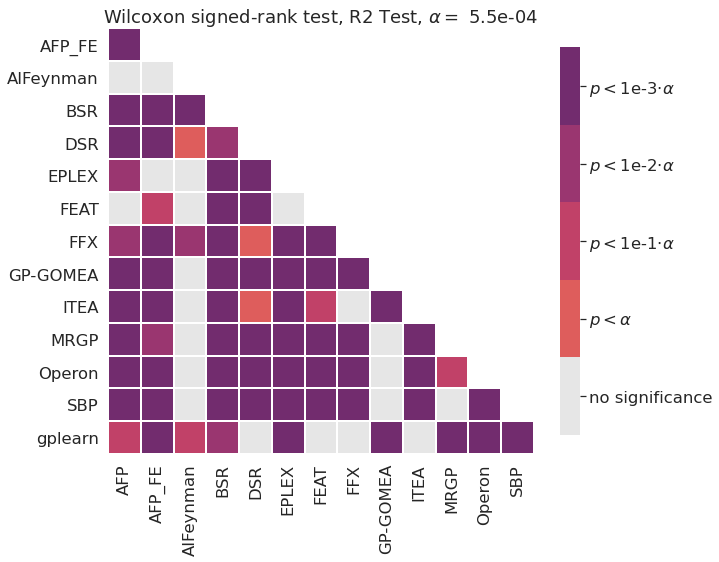

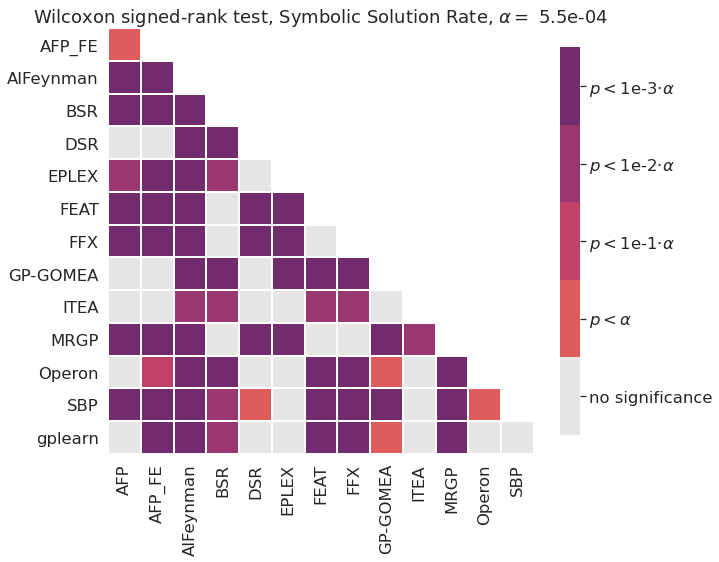

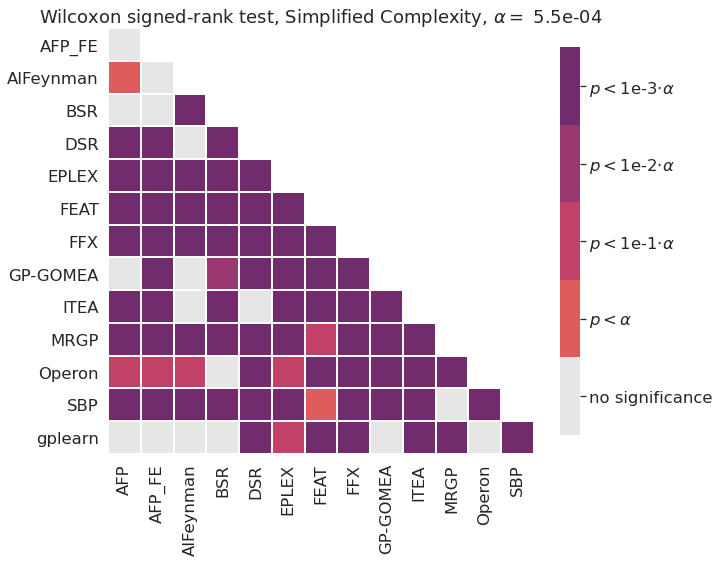

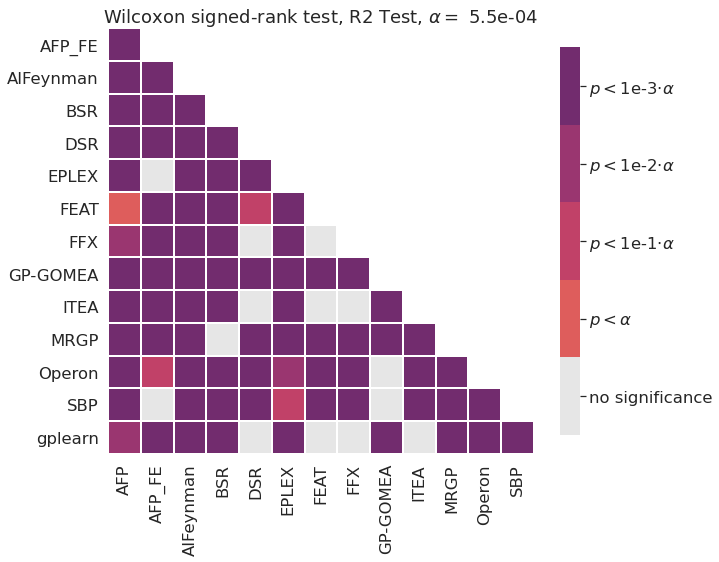

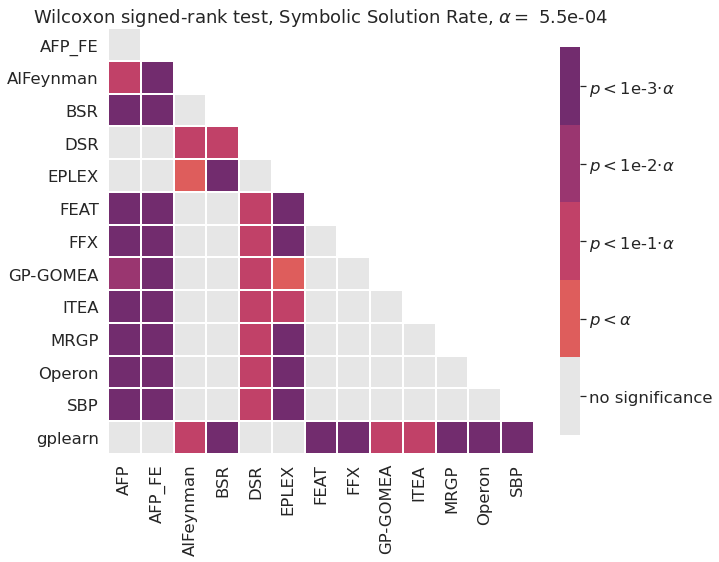

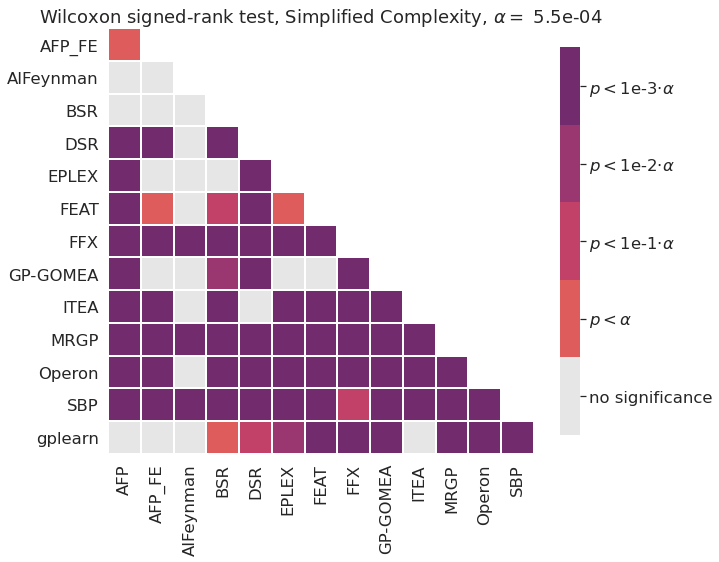

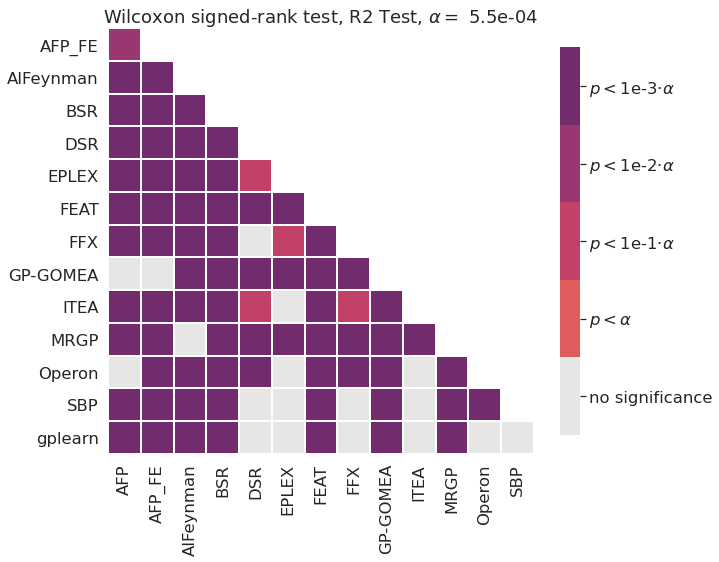

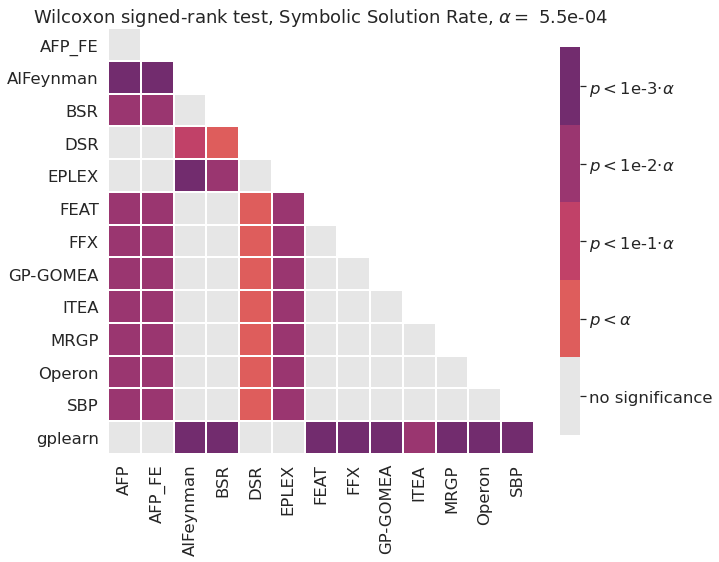

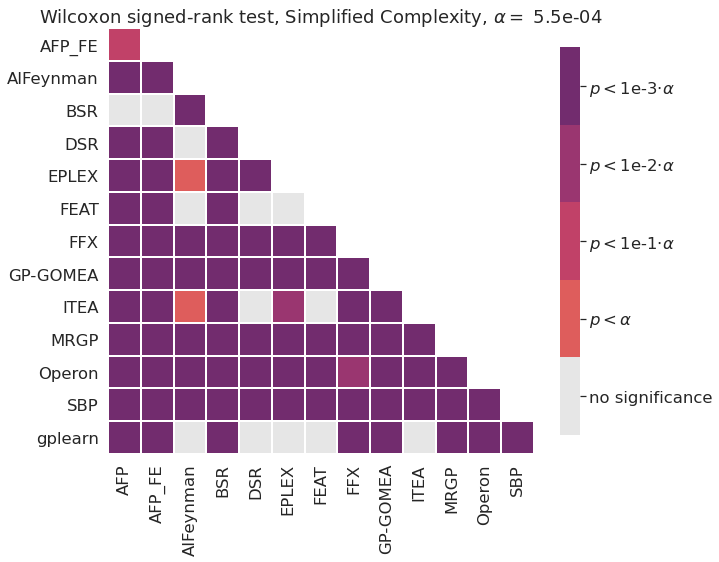

In [8]:
# for metric in ['r2_test','symbolic_solution_rate','simplified_complexity']:
#     name = 'symbolic problems'
#     pval_heatmap(df_sum_filled, metric, name, algs)
    
for target_noise, dfg in df_sum_filled.groupby('target_noise'):
    for metric in ['r2_test','symbolic_solution_rate','simplified_complexity']:
        name = 'symbolic problems target_noise='+str(target_noise)
        pval_heatmap(dfg, metric, name, algs)
    

# Black-Box datasets

## load data and fill nan results

In [9]:
df_sum = pd.read_csv('results_pmlb_r1_summary.csv.gz')
algs = df_sum.algorithm.unique()
datasets = df_sum.dataset.unique()
print(len(algs),'algorithms:',algs)
print(len(datasets),'datasets')

cols = df_sum.columns
for dataset in datasets:
    df = df_sum.loc[df_sum.dataset == dataset]
    for alg in algs:
        if alg not in df.algorithm.unique():
            print(alg,'missing for',dataset)
            


21 algorithms: ['AFP' 'AFP_FE' 'AIFeynman' 'AdaBoost' 'BSR' 'DSR' 'EPLEX' 'FEAT' 'FFX'
 'GP-GOMEA' 'ITEA' 'KernelRidge' 'LGBM' 'Linear' 'MLP' 'MRGP' 'Operon'
 'RandomForest' 'SBP' 'XGB' 'gplearn']
122 datasets
AIFeynman missing for 1191_BNG_pbc
KernelRidge missing for 1191_BNG_pbc
KernelRidge missing for 1196_BNG_pharynx
KernelRidge missing for 1595_poker
AIFeynman missing for 197_cpu_act
AIFeynman missing for 201_pol
AIFeynman missing for 294_satellite_image
AIFeynman missing for 4544_GeographicalOriginalofMusic
AIFeynman missing for 505_tecator
AIFeynman missing for 573_cpu_act
AIFeynman missing for 574_house_16H
AIFeynman missing for 581_fri_c3_500_25
AIFeynman missing for 583_fri_c1_1000_50
AIFeynman missing for 584_fri_c4_500_25
AIFeynman missing for 586_fri_c3_1000_25
AIFeynman missing for 588_fri_c4_1000_100
AIFeynman missing for 592_fri_c4_1000_25
AIFeynman missing for 622_fri_c2_1000_50


In [10]:
algs

array(['AFP', 'AFP_FE', 'AIFeynman', 'AdaBoost', 'BSR', 'DSR', 'EPLEX',
       'FEAT', 'FFX', 'GP-GOMEA', 'ITEA', 'KernelRidge', 'LGBM', 'Linear',
       'MLP', 'MRGP', 'Operon', 'RandomForest', 'SBP', 'XGB', 'gplearn'],
      dtype=object)

In [11]:
# if a result is missing, assign it the worst ranking
# cols = df_sum.columns
filler_frame = {
    'r2_test_rank' : len(algs)+1,
    'model_size_rank' : len(algs)+1,
}
fill_frames = []
j = 0
for dataset in datasets:
    for alg in algs:
        df = df_sum.loc[df_sum.dataset == dataset]
        if alg not in df.algorithm.unique():
            print('filling',alg,'missing for',dataset)
#                 for col in cols:
            new_fill = filler_frame.copy()
            new_fill.update({
                             'algorithm':alg,
                             'dataset':dataset,
                            })
            print(new_fill)
            fill_frames.append(new_fill)
            j += 1
            
df_fill = pd.DataFrame.from_records(fill_frames, columns=fill_frames[0].keys()) 
df_sum_filled = df_sum.append(df_fill)


filling AIFeynman missing for 1191_BNG_pbc
{'r2_test_rank': 22, 'model_size_rank': 22, 'algorithm': 'AIFeynman', 'dataset': '1191_BNG_pbc'}
filling KernelRidge missing for 1191_BNG_pbc
{'r2_test_rank': 22, 'model_size_rank': 22, 'algorithm': 'KernelRidge', 'dataset': '1191_BNG_pbc'}
filling KernelRidge missing for 1196_BNG_pharynx
{'r2_test_rank': 22, 'model_size_rank': 22, 'algorithm': 'KernelRidge', 'dataset': '1196_BNG_pharynx'}
filling KernelRidge missing for 1595_poker
{'r2_test_rank': 22, 'model_size_rank': 22, 'algorithm': 'KernelRidge', 'dataset': '1595_poker'}
filling AIFeynman missing for 197_cpu_act
{'r2_test_rank': 22, 'model_size_rank': 22, 'algorithm': 'AIFeynman', 'dataset': '197_cpu_act'}
filling AIFeynman missing for 201_pol
{'r2_test_rank': 22, 'model_size_rank': 22, 'algorithm': 'AIFeynman', 'dataset': '201_pol'}
filling AIFeynman missing for 294_satellite_image
{'r2_test_rank': 22, 'model_size_rank': 22, 'algorithm': 'AIFeynman', 'dataset': '294_satellite_image'}
fi

## generate tables

In [12]:
# baseline significance threshold; adjusted for no. of comparisons below
alpha = 0.05
BB_pvals = {}

for metric in ['r2_test','model_size']:
    pvals = []

    n = 0 
    df_pvals, c_alpha = get_pval_df(df_sum_filled, metric, algs) 
#     for alg1, alg2 in it.combinations(algs, 2):
#         pval, eff_size = pairwise_pval(df_sum_filled, metric, alg1, alg2)
#         pvals.append(dict(
#             alg1 = alg1,
#             alg2 = alg2,
#             eff_size = eff_size,
#             pval = pval
#         ))
#         n += 1
#     corrected_alpha = alpha/n
#     print('alpha:',corrected_alpha) 
#     df_pvals = pd.DataFrame.from_records(pvals)
#     # significance
#     # significance
#     df_pvals.loc[:,'eff_size_bold'] = df_pvals.apply(lambda x: signif(x['pval'], 
#                                                                       corrected_alpha,
#                                                                       x['eff_size'])[1],
#                                                      axis=1
#                                                     )
    pval_tbl = df_pvals.set_index(['alg1','alg2'])['pval'].unstack() 
    BB_pvals[metric] = pval_tbl.copy() 
    pval_tbl = pval_tbl.fillna('-')
#     pval_tbl = df_pvals.set_index(['alg1','alg2'])['eff_size_bold'].unstack().fillna('-')
    display(pval_tbl)
   
    caption = ('Pairwise comparisons of {} across the black-box datasets. '
              'Bold indicates significant differences ($p<\\alpha$, $\\alpha=${:1.1g}).').format(
                    metric.replace('_',' ').replace('%','\%').title(), 
                    c_alpha
                    )
    tbl = pval_tbl.to_latex(
                      caption=caption,
                      column_format='l '+' '.join(['p{3em}' for c in range(pval_tbl.shape[1])]),
#                       formatters=[lambda x: signif(x, c_alpha) for c in pval_tbl.columns],
#                       label='tbl:pval-sr-'+metric.replace('_','-')
                     )
    tbl = tbl.replace('\centering','\centering\n\\tiny')
    tbl = tbl.replace('textbf','\\textbf')
    tbl = tbl.replace('\\{','{').replace('\\}','}')
    print(tbl)
    with open('../../paper/tables/pvals_bb_'+metric.replace('%','pct')+'.tex','w') as f:
        f.write(tbl)
    pval_tbl

n: 210 c_alpha: 0.0002380952380952381


alg2,AFP_FE,AIFeynman,AdaBoost,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,KernelRidge,LGBM,Linear,MLP,MRGP,Operon,RandomForest,SBP,XGB,gplearn
alg1,,,,,,,,,,,,,,,,,,,,
AFP,0.473574,0.0,0.0,0.0,0.0,0.0,0.0,0.082092,0.0,0.199182,0.155812,0.02367,0.0,0.006841,0.00105,0.0,0.000068,0.0,0.0,5.399574e-12
AFP_FE,-,0.0,0.0,0.0,0.0,0.0,0.0,0.099097,0.0,0.402727,0.102813,0.031959,0.0,0.002433,0.0004,0.0,0.000196,0.0,0.0,4.847601e-14
AIFeynman,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.378377e-17
AdaBoost,-,-,-,0.0,0.0,0.0,0.0,0.006894,0.0,0.044484,0.004336,0.052627,0.0,0.000101,0.000001,0.0,0.767916,0.0,0.0,1.397865e-15
BSR,-,-,-,-,0.0,0.0,0.0,0.000061,0.0,0.0,0.0,0.0,0.0,0.0,0.000005,0.0,0.0,0.0,0.0,1.565685e-17
DSR,-,-,-,-,-,0.0,0.0,0.762067,0.0,0.000006,0.05294,0.000734,0.000025,0.2838,0.69303,0.0,0.0,0.0,0.0,4.441397e-01
EPLEX,-,-,-,-,-,-,0.000003,0.0,0.007615,0.0,0.000026,0.000396,0.0,0.000004,0.0,0.0,0.0,0.0,0.152122,1.980574e-16
FEAT,-,-,-,-,-,-,-,0.0,0.0,0.0,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.000301,0.02274,1.200820e-17
FFX,-,-,-,-,-,-,-,-,0.000001,0.009974,0.163393,0.009828,0.066771,0.734959,0.648342,0.0,0.005167,0.0,0.0,5.304942e-01


\begin{table}
\centering
\tiny
\caption{Pairwise comparisons of R2 Test across the black-box datasets. Bold indicates significant differences ($p<\alpha$, $\alpha=$0.0002).}
\begin{tabular}{l p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em}}
\toprule
alg2 &    AFP\_FE & AIFeynman & AdaBoost &  BSR &  DSR & EPLEX &      FEAT &       FFX &  GP-GOMEA &      ITEA & KernelRidge &      LGBM &    Linear &       MLP &      MRGP & Operon & RandomForest &       SBP &       XGB &       gplearn \\
alg1         &           &           &          &      &      &       &           &           &           &           &             &           &           &           &           &        &              &           &           &               \\
\midrule
AFP          &  0.473574 &       0.0 &      0.0 &  0.0 &  0.0 &   0.0 &       0.0 &  0.082092 &       0.0 &  0.199182 &    0.155812 &   0.02367 &       0.0 &  0.0

alg2,AFP_FE,AIFeynman,AdaBoost,BSR,DSR,EPLEX,FEAT,FFX,GP-GOMEA,ITEA,KernelRidge,LGBM,Linear,MLP,MRGP,Operon,RandomForest,SBP,XGB,gplearn
alg1,,,,,,,,,,,,,,,,,,,,
AFP,0.177281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.693180e-20
AFP_FE,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.950480e-20
AIFeynman,-,-,0.0,0.0,0.0,0.0,0.0,0.026399,0.0,0.0,0.0001,0.0,0.0,0.0,0.0,0.0,0.0,0.000003,0.0,3.278247e-18
AdaBoost,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.239365,0.0,0.0,0.0,0.063789,9.237152e-22
BSR,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009605,0.0,0.0,0.0,0.0,0.0,0.0,7.783701e-02
DSR,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005956,0.0,0.0,0.0,0.0,0.0,0.0,3.148710e-13
EPLEX,-,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000067,0.0,0.0,0.0,9.127201e-22
FEAT,-,-,-,-,-,-,-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007554,0.0,0.0,0.0,2.663786e-21
FFX,-,-,-,-,-,-,-,-,0.0,0.0,0.000031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.238902e-22


\begin{table}
\centering
\tiny
\caption{Pairwise comparisons of Model Size across the black-box datasets. Bold indicates significant differences ($p<\alpha$, $\alpha=$0.0002).}
\begin{tabular}{l p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em} p{3em}}
\toprule
alg2 &    AFP\_FE & AIFeynman & AdaBoost &  BSR &  DSR & EPLEX & FEAT &       FFX & GP-GOMEA & ITEA & KernelRidge & LGBM &    Linear &       MLP &      MRGP &    Operon & RandomForest &       SBP &       XGB &       gplearn \\
alg1         &           &           &          &      &      &       &      &           &          &      &             &      &           &           &           &           &              &           &           &               \\
\midrule
AFP          &  0.177281 &       0.0 &      0.0 &  0.0 &  0.0 &   0.0 &  0.0 &       0.0 &      0.0 &  0.0 &         0.0 &  0.0 &       0.0 &       0.0 &       0.0 &       0.0 &        

n: 210 c_alpha: 0.0002380952380952381
saving ../../paper/figs//Pairwise_comparison_of_R2_Test_on_black-box_problems.pdf


/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


n: 210 c_alpha: 0.0002380952380952381
saving ../../paper/figs//Pairwise_comparison_of_Model_Size_on_black-box_problems.pdf


/home/bill/anaconda3/envs/srbench/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


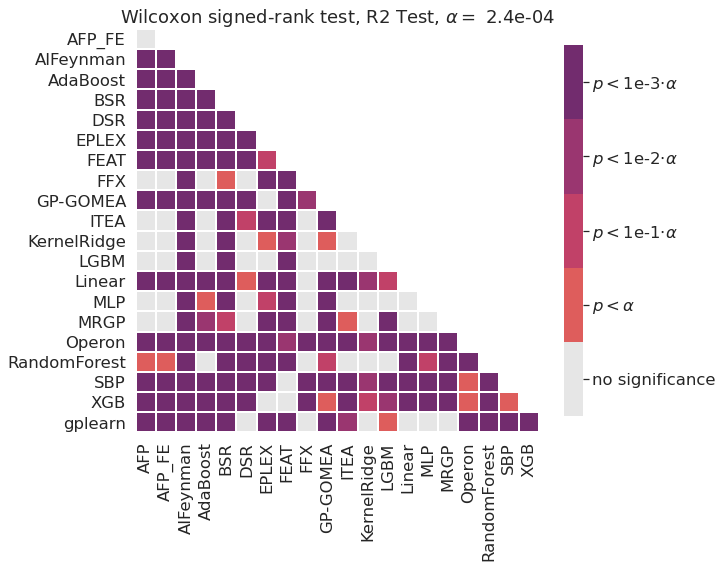

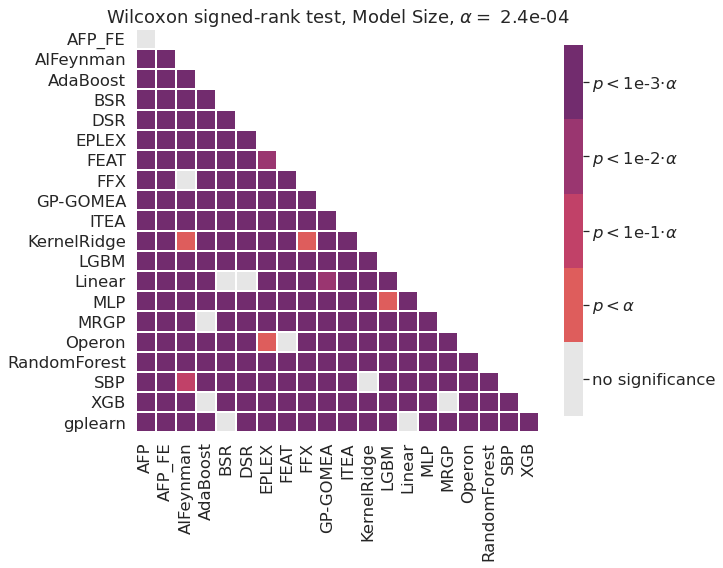

In [13]:
for metric in ['r2_test','model_size']:
    name = 'black-box problems'
    pval_heatmap(df_sum_filled, metric, name, algs)

## specific p-values referenced in manuscript

In [14]:
# first fill the matrices so we can look at either pair
for k,v in BB_pvals.items():
    algs = v.columns
    for alg1, alg2 in it.combinations(algs,2):
        if np.isnan(BB_pvals[k].loc[alg1,alg2]): 
            BB_pvals[k].loc[alg1,alg2] = BB_pvals[k].loc[alg2,alg1] 
        else:
            BB_pvals[k].loc[alg2,alg1] = BB_pvals[k].loc[alg1,alg2] 

Operon performance on BB problems

In [15]:
BB_pvals['r2_test']['Operon'] #.max() #.replace('-','0').astype(float).max() #.round(2)

alg1
AFP             4.847056e-12
AFP_FE          8.149749e-12
AIFeynman       5.144925e-20
AdaBoost        2.798142e-10
BSR             2.056980e-19
DSR             2.338511e-14
EPLEX           8.072967e-10
FEAT            4.917288e-07
FFX             2.772662e-17
GP-GOMEA        3.400749e-09
ITEA            1.687041e-12
KernelRidge     4.917393e-07
LGBM            3.027897e-12
Linear          3.084280e-14
MLP             4.886911e-10
MRGP            1.199128e-20
Operon                   NaN
RandomForest    1.060295e-09
SBP             3.506290e-05
XGB             6.476527e-05
gplearn         5.450962e-14
Name: Operon, dtype: float64

FEAT model size vs SGP

In [16]:
BB_pvals['model_size'].loc['FEAT','SBP']

9.23890220222e-22

GP models smaller than ensemble tree methods

In [17]:
import itertools as it
import numpy as np

gps = ['Operon','FEAT','EPLEX','ITEA','GP-GOMEA']
trees = ['LGBM','XGB','RandomForest','AdaBoost']
BB_pvals['model_size'].loc[gps,trees].max().max()
# ps = []
# for alg1,alg2 in it.product(gps, trees):
#     if np.isnan(BB_pvals['model_size'].loc[alg1,alg2]): 
#         ps.append(BB_pvals['model_size'].loc[alg2,alg1] )
#     else:
#         ps.append(BB_pvals['model_size'].loc[alg1,alg2])

# np.max(ps)

1.3384168364165253e-21

In [18]:
BB_pvals['r2_test'].loc[['DSR','BSR','FFX','AIFeynman'],['DSR','BSR','FFX','AIFeynman']]
# display(BB_pvals['r2_test'].loc['DSR',:])

alg2,DSR,BSR,FFX,AIFeynman
alg1,,,,
DSR,NaN,1.788424e-19,7.620675e-01,4.606728e-18
BSR,1.788424e-19,NaN,6.070200e-05,1.330426e-13
FFX,7.620675e-01,6.070200e-05,NaN,5.194182e-15
AIFeynman,4.606728e-18,1.330426e-13,5.194182e-15,NaN


In [19]:
BB_pvals['r2_test'].loc[['DSR','FFX'],['BSR','AIFeynman']]
# display(BB_pvals['r2_test'].loc['DSR',:])

alg2,BSR,AIFeynman
alg1,,
DSR,1.788424e-19,4.606728e-18
FFX,6.070200e-05,5.194182e-15


In [20]:
BB_pvals['r2_test'][['BSR','AIFeynman']]
# display(BB_pvals['r2_test'].loc['DSR',:])

alg2,BSR,AIFeynman
alg1,,
AFP,3.483640e-21,8.613339e-19
AFP_FE,5.532002e-21,5.196554e-19
AIFeynman,1.330426e-13,NaN
AdaBoost,3.399650e-21,1.119979e-19
BSR,NaN,1.330426e-13
DSR,1.788424e-19,4.606728e-18
EPLEX,4.338090e-21,9.959092e-20
FEAT,3.317664e-21,4.058853e-20
FFX,6.070200e-05,5.194182e-15
